In [2]:
# import libraries used
import pandas as pd
import ast
from nltk.corpus import stopwords
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, PartOfSpeech
from transformers import pipeline       # Hugging Face model
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import gensim

### Load data

In [5]:
data = pd.read_csv("../datasetsUsed/cleanedComp.csv").drop(["Unnamed: 0"], axis=1)

In [3]:
# read text file that is saved with "tokens" in the 2nd data pre-process part
with open("testFile.txt", "r", encoding = "utf-8", errors = "ignore") as fi:
    hh = fi.read()

# change data type
testArray = ast.literal_eval(hh)

In [6]:
data['tokens'] = testArray

In [ ]:
sgPos = data[(data['Country'] == "Singapore") & (data['polarity1'] == "positive")]
sgNeg = data[(data['Country'] == "Singapore") & (data['polarity1'] == "negative")]
print("Sin Pos: ", len(sgPos))
print("Sin Neg: ", len(sgNeg))

thPos = data[(data['Country'] == "Thailand") & (data['polarity1'] == "positive")]
thNeg = data[(data['Country'] == "Thailand") & (data['polarity1'] == "negative")]
print("Tha Pos: ", len(thPos))
print("Tha Neg: ", len(thNeg))

trPos = data[(data['Country'] == "Turkey") & (data['polarity1'] == "positive")]
trNeg = data[(data['Country'] == "Turkey") & (data['polarity1'] == "negative")]
print("Tur Pos: ", len(trPos))
print("Tur Neg: ", len(trNeg))

### to remove stopwords - redundant

In [ ]:
nlp = en_core_web_md.load()

# Tags I want from the text
allowed_postags = ['NOUN', 'ADJ', 'VERB']
tokens = []

for i in nlp.pipe(data['cleanedTransCom']):
   proj_tok = [token.lemma_ for token in i if token.pos_ in allowed_postags]
   tokens.append(proj_tok)

tokens

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(["accomodation", "place", "re", "edu", "use", "br", "s","d", "be", "b", "comment",
                   "nil", "say", "stay", "appartment", "thank", "take" "day", "airbnb", "airbnbs",
                   "ve", "bk", "pk", "belinda", "make", ""])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
# tokens = remove_stopwords(testArray)
tokens = remove_stopwords(tokens)

# to overwrite data["tokens"] for the newly cleaned array
data['tokens'] = tokens

In [7]:
sgPos = data[(data['Country'] == "Singapore") & (data['polarity1'] == "positive")]
sgNeg = data[(data['Country'] == "Singapore") & (data['polarity1'] == "negative")]
print("Sin Pos: ", len(sgPos))
print("Sin Neg: ", len(sgNeg))

thPos = data[(data['Country'] == "Thailand") & (data['polarity1'] == "positive")]
thNeg = data[(data['Country'] == "Thailand") & (data['polarity1'] == "negative")]
print("Tha Pos: ", len(thPos))
print("Tha Neg: ", len(thNeg))

trPos = data[(data['Country'] == "Turkey") & (data['polarity1'] == "positive")]
trNeg = data[(data['Country'] == "Turkey") & (data['polarity1'] == "negative")]
print("Tur Pos: ", len(trPos))
print("Tur Neg: ", len(trNeg))

Sin Pos:  31895
Sin Neg:  1829
Tha Pos:  308128
Tha Neg:  14774
Tur Pos:  461425
Tur Neg:  22274


# Topic Modelling

## BERTopic

#### base BERT model, before tuning (bad model)

In [98]:
badBERTModel = BERTopic()
badTopics, badprobs = badBERTModel.fit_transform(sgNeg["tokensForBERT"])

In [215]:
badBERTModel.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1789,0_room_place_good_clean,"[room, place, good, clean, bed, check, night, ...","[['get', 'different', 'room', 'photo', 'right'..."
1,1,40,1____,"[, , , , , , , , , ]","[[], [], []]"


In [100]:
badBERTModel.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

From the error above, it's shown that using BERTopic's base model is not suitable for our use case. Since the topics are not able to be visualised properly.
</br>
</br>
Plus, from the bar-chart below, there are no topics to be generated for the Singapore's negative reviews using BERTopic basemodel.

In [101]:
badBERTModel.visualize_barchart()

#### Declare instance for BERTopic models: 

In [16]:
# Use the representation model in BERTopic on top of the default pipeline
repModel = MaximalMarginalRelevance(diversity=0.3)
representation_model = PartOfSpeech("en_core_web_sm")
nr_topics = "auto"

In [17]:
# Positive and Negative topic models for each country

# Parts Of Sppech to fine tune
# Sing Pos & Neg models
sgPosTopicMod = BERTopic(representation_model=representation_model)
sgNegTopicMod = BERTopic(representation_model=representation_model)
# Thai Pos & Neg models
thPosTopicMod = BERTopic(representation_model=representation_model)
thNegTopicMod = BERTopic(representation_model=representation_model)
# Turk Pos & Neg models
trPosTopicMod = BERTopic(representation_model=representation_model)
trNegTopicMod = BERTopic(representation_model=representation_model)

# Maximal Marginal Relevance to fine tune
# Sing Pos & Neg models
sgPosMMR = BERTopic(representation_model=repModel)
sgNegMMR = BERTopic(representation_model=repModel)

#### Singapore

In [57]:
# Model topics for Singpore's positive & negative reviews.
sgPosTopics, sgPosprobs = sgPosTopicMod.fit_transform(sgPos["transComments"])
sgNegTopics, sgNegprobs = sgNegTopicMod.fit_transform(sgNeg["transComments"])

sgPosMMRTopics, sgPosMMRprobs = sgPosMMR.fit_transform(sgPos["transComments"])
sgNegMMRTopics, sgNegMMRprobs = sgNegMMR.fit_transform(sgNeg["transComments"])

In [62]:
sgPosMerged = BERTopic.merge_models([sgPosTopicMod, sgPosMMR])
sgNegMerged = BERTopic.merge_models([sgNegTopicMod, sgNegMMR])

##### Sing Positive

In [60]:
print("Singapore Positive BERT topics - PartsOfSpeech: ")
display(sgPosTopicMod.get_topic_info().head())
sgPosTopicMod.visualize_barchart()

Singapore Positive BERT topics - PartsOfSpeech: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,12732,-1_room_stay_clean_good,"[room, stay, clean, good, great, location, pla...",[We enjoy and love our stay in this house very...
1,0,1303,0_station_close_walk_bus,"[station, close, walk, bus, distance, walking,...","[It was near on bus and mrt station., Nice pla..."
2,1,568,1_chinatown_heart_location_walk,"[chinatown, heart, location, walk, food, mary,...",[Great place to stay at! Close to Chinatown MR...
3,2,499,2_apartment_apartments_clean_nice,"[apartment, apartments, clean, nice, location,...","[Great location and clean apartment., Great lo..."
4,3,433,3_hostel_hostels_breakfast_staff,"[hostel, hostels, breakfast, staff, capsule, b...","[Great hostel!, Great hostel, great hostel]"


In [61]:
print("Singapore Positive BERT topics - MaximalMarginalRelevance: ")
display(sgPosMMR.get_topic_info().head())
sgPosMMR.visualize_barchart()

Singapore Positive BERT topics - MaximalMarginalRelevance: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,14074,-1_the_was_room_very,"[the, was, room, very, in, clean, stay, with, ...",[I stayed in that room for a long time(40 days...
1,0,420,0_hostel_hostels_breakfast_staff,"[hostel, hostels, breakfast, staff, beds, caps...","[Great hostel!, Great Hostel!, Very great host..."
2,1,288,1_clean_place_cleanliness_tidy,"[clean, place, cleanliness, tidy, central, org...","[Very clean and good location, nice place!, Gr..."
3,2,282,2_airbnb_first_experience_best,"[airbnb, first, experience, best, ever, host, ...","[Its good for airbnb., Nice airbnb, good Airbnb]"
4,3,270,3_eddie_eddies_edwin_airport,"[eddie, eddies, edwin, airport, house, houseke...",[We thoroughly enjoyed our stay at Eddies. We ...


In [63]:
print("Singapore Positive BERT topics - Merged: ")
display(sgPosMerged.get_topic_info().head())
sgPosMerged.visualize_barchart()

Singapore Positive BERT topics - Merged: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,26819,-1_room_stay_clean_good,"[room, stay, clean, good, great, location, pla...",NaN
1,0,1848,0_station_close_walk_bus,"[station, close, walk, bus, distance, walking,...",NaN
2,1,924,1_chinatown_heart_location_walk,"[chinatown, heart, location, walk, food, mary,...",NaN
3,2,787,2_apartment_apartments_clean_nice,"[apartment, apartments, clean, nice, location,...",NaN
4,3,863,3_hostel_hostels_breakfast_staff,"[hostel, hostels, breakfast, staff, capsule, b...",NaN


##### Sing Negative

In [88]:
print("Singapore Negative BERT topics - PartsOfSpeech: ")
display(sgNegTopicMod.get_topic_info().head())
# sgNegTopicMod.get_topic_info().head()["Representative_Docs"]
print(len(sgNegTopicMod.get_topic_info()))
sgNegTopicMod.visualize_barchart()

Singapore Negative BERT topics - PartsOfSpeech: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,777,-1_room_place_good_bed,"[room, place, good, bed, night, small, apartme...",[Our family reserved an entire room with 20 be...
1,0,118,0_airbnb_in_host_room,"[airbnb, in, host, room, refund, stay, booking...",[The experience in Rajan’s house had NOT A THI...
2,1,115,1_noisy_noise_loud_room,"[noisy, noise, loud, room, night, sound, in, s...","[The Good: The space is great. Clean, convenie..."
3,2,109,2_room_one_place_good,"[room, one, place, good, location, price, only...","[To be honest, we were relieved we only stayed..."
4,3,81,3_room_small_pictures_different,"[room, small, pictures, different, photo, smal...",[Room is very small and common areas are not u...


29

In [64]:
print("Singapore Negative BERT topics - MaximalMarginalRelevance: ")
display(sgNegMMR.get_topic_info().head())
print(len(sgNegMMR.get_topic_info()))
sgNegMMR.visualize_barchart()

Singapore Negative BERT topics - MaximalMarginalRelevance: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,12,-1_go_dont_worst_exorcism,"[go, dont, worst, exorcism, waste, attitude, c...","[Dont want to visit again... never, AVOID AT A..."
1,0,1747,0_to_is_in_room,"[to, is, in, room, very, there, were, at, my, be]","[The first time I used airbnb, it was actually..."
2,1,27,1_comments_repeat_again_wont,"[comments, repeat, again, wont, say, comeback,...","[Nothing!, Please see my private note as I am ..."
3,2,19,2_nil_cghk_nc_gd,"[nil, cghk, nc, gd, 121, discommunicate, abit,...","[NIL, Nil, nil]"
4,3,12,3_recommended_diligent_improvement_advised,"[recommended, diligent, improvement, advised, ...","[not bad but it can be better, Not recommended..."


6


In [66]:
print("Singapore Negative BERT topics - Merged: ")
display(sgNegMerged.get_topic_info().head())
print(len(sgNegMerged.get_topic_info()))
sgNegMerged.visualize_barchart()

Singapore Negative BERT topics - Merged: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2492,-1_in_room_place_good,"[in, room, place, good, clean, bed, night, sma...",NaN
1,0,116,0_airbnb_host_room_refund,"[airbnb, host, room, refund, stay, place, chec...",NaN
2,1,111,1_noisy_noise_loud_room,"[noisy, noise, loud, room, night, sound, in, s...",NaN
3,2,109,2_room_one_place_good,"[room, one, place, good, location, price, smal...",NaN
4,3,88,3_host_check_app_key,"[host, check, app, key, room, service, great, ...",NaN


30


In [ ]:
sgNegTopicMod.get_representative_docs()

In [ ]:
sgNegTopicMod.visualize_topics()

#### Thailand

In [18]:
# Model topics for Thailand's positive & negative reviews.
thPosTopics, thPosprobs = thPosTopicMod.fit_transform(thPos["transComments"])
thNegTopics, thNegprobs = thNegTopicMod.fit_transform(thNeg["transComments"])

##### Thai Positive

In [43]:
print("Thailand Positive BERT topics - PartsOfSpeech")
display(thPosTopicMod.get_topic_info().head())
print(len(thPosTopicMod.get_topic_info()))
thPosTopicMod.visualize_barchart()

Thailand Positive BERT topics - PartsOfSpeech


,Topic,Count,Name,Representation,Representative_Docs
0,-1,146775,-1_room_stay_good_place,"[room, stay, good, place, great, clean, locati...","[The place was VERY NICE, exactly what the pic..."
1,0,66392,0_condo_place_stay_great,"[condo, place, stay, great, clean, apartment, ...",[Very good place and the room are clean and co...
2,1,57126,1_location_good_great_nice,"[location, good, great, nice, pool, place, cle...","[Very good room, nice pool, clean, Very nice r..."
3,2,18998,2_host_accommodation_great_very,"[host, accommodation, great, very, place, stay...","[Very good, clean accommodation, great locatio..."
4,3,2209,3_stay_great_place_second,"[stay, great, place, second, time, nice, thank...","[Great place will stay again, Great place , wi..."


108


In [36]:
# reduce topics using nr_topics = "auto"
reduceThPosMod = thPosTopicMod.reduce_topics(thPos["transComments"], nr_topics = 108)

In [40]:
display(reduceThPosMod.get_topic_info())
reduceThPosMod.visualize_barchart()
# len(reduceThPosMod.get_topic_info())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,146775,-1_room_stay_good_place,"[room, stay, good, place, great, clean, locati...","[The place was VERY NICE, exactly what the pic..."
1,0,66392,0_condo_place_stay_great,"[condo, place, stay, great, clean, apartment, ...",[Very good place and the room are clean and co...
2,1,57126,1_location_good_great_nice,"[location, good, great, nice, pool, place, cle...","[Very good room, nice pool, clean, Very nice r..."
3,2,18998,2_host_accommodation_great_very,"[host, accommodation, great, very, place, stay...","[Very good, clean accommodation, great locatio..."
4,3,2209,3_stay_great_place_second,"[stay, great, place, second, time, nice, thank...","[Great place will stay again, Great place , wi..."
...,...,...,...,...,...
103,102,14,102_opal_gate_host_carefree,"[opal, gate, host, carefree, house, help, grea...",[Opal was a great host and a great help when w...
104,103,13,103_suitable_pictures_photos_goodplace,"[suitable, pictures, photos, goodplace, housek...","[Very suitable for taking pictures, beautiful ..."
105,104,12,104_hustle_bustle_quiet_hideaway,"[hustle, bustle, quiet, hideaway, middle, nest...","[Very nice, good location, quiet in the middle..."
106,105,11,105_punt_unit_greyhound_sachet,"[punt, unit, greyhound, sachet, apt, neighborh...",[We loved punt place its spacious for us 3 per...


##### Thai Negative

In [42]:
print("Thailand Negative BERT topics - PartsOfSpeech")
display(thNegTopicMod.get_topic_info().head())
# len(thNegTopicMod.get_topic_info())
thNegTopicMod.visualize_barchart()

Thailand Negative BERT topics - PartsOfSpeech


,Topic,Count,Name,Representation,Representative_Docs
0,-1,7014,-1_room_host_apartment_place,"[room, host, apartment, place, good, stay, loc...",[This was the most terrible experience I ever ...
1,0,1375,0_in_stay_place_room,"[in, stay, place, room, only, time, apartment,...","[The family stayed here for four days, and the..."
2,1,493,1_noisy_noise_sound_loud,"[noisy, noise, sound, loud, sleep, night, road...","[Good location. But but noisy, The location of..."
3,2,350,2_bts_walk_station_close,"[bts, walk, station, close, bit, location, min...","[Very good~ but bts so far~!, A bit far from B..."
4,3,272,3_cockroaches_cockroach_apartment_kitchen,"[cockroaches, cockroach, apartment, kitchen, r...",[About 10 minutes walk from the station. <br/>...


In [50]:
reduceThNegMod = thNegTopicMod.reduce_topics(thNeg["transComments"], nr_topics)

In [53]:
display(reduceThNegMod.get_topic_info())
len(reduceThNegMod.get_topic_info())
reduceThNegMod.visualize_barchart()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7014,-1_room_host_apartment_place,"[room, host, apartment, place, good, location,...",[There was a slight mix-up when I arrived beca...
1,0,7411,0_room_good_place_location,"[room, good, place, location, stay, apartment,...",[CHEAP CAN BE Expensive!!<br/>I booked this li...
2,1,231,1_review_previous_bad_good,"[review, previous, bad, good, response, quick,...","[See previous review., See my previous review,..."
3,2,35,2_class_nice_room_,"[class, nice, room, , , , , , , ]","[class🔔, I decline🙂, xxxx]"
4,3,33,3_next_time_book_opportunity,"[next, time, book, opportunity, year, future, ...",[I will definitely book here again next time I...
5,4,15,4_flat_front_nice_house,"[flat, front, nice, house, everyghing, score, ...","[great flat..., clean flat, It was a nice flat.]"
6,5,12,5_recommendable_health_friends_issues,"[recommendable, health, friends, issues, good,...","[I don't recommend it, I don’t Recommend it, N..."
7,6,12,6_basic_money_more_,"[basic, money, more, , , , , , , ]","[you get what you pay for, You get what you pa..."
8,7,11,7_improvement_better_things_heaps,"[improvement, better, things, heaps, report, a...","[Some things to improve, Need to improve, Can ..."


#### Turkey

In [19]:
# Model topics for Thailand's positive & negative reviews.
trPosTopics, trPosprobs = trPosTopicMod.fit_transform(trPos["transComments"])
trNegTopics, trNegprobs = trNegTopicMod.fit_transform(trNeg["transComments"])

##### Turk Positive

In [ ]:
print("Turkey Positive BERT topics: - PartsOfSpeech ")
display(trPosTopicMod.get_topic_info().head())
print(len(trPosTopicMod.get_topic_info()))
trPosTopicMod.visualize_barchart()

In [54]:
reduceTrPosMod = trPosTopicMod.reduce_topics(trPos["transComments"], nr_topics)

In [ ]:
# display(reduceTrPosMod.get_topic_info())
# len(reduceTrPosMod.get_topic_info())
# reduceTrPosMod.visualize_barchart()

display(trPosTopicMod.get_topic_info())
len(trPosTopicMod.get_topic_info())
trPosTopicMod.visualize_barchart()

##### Turk Negative

In [46]:
print("Turkey Negative BERT topics:  - PartsOfSpeech ")
display(trNegTopicMod.get_topic_info().head())
print(len(trNegTopicMod.get_topic_info()))
trNegTopicMod.visualize_barchart()

Turkey Negative BERT topics:  - PartsOfSpeech 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,10545,-1_apartment_room_place_location,"[apartment, room, place, location, good, only,...",[The apartment is located very close to Sultan...
1,0,1674,0_istanbul_apartment_stay_place,"[istanbul, apartment, stay, place, one, time, ...",[We made booking for 4 people but when we chec...
2,1,1088,1_airbnb_host_refund_place,"[airbnb, host, refund, place, experience, mone...",[The listing misrepresents the unit.<br/>I wis...
3,2,895,2_noise_noisy_loud_night,"[noise, noisy, loud, night, sleep, apartment, ...",[There is not much lighting in the accommodati...
4,3,878,3_host_good_place_nice,"[host, good, place, nice, friendly, hosts, loc...",[The host is always reachable and willing to h...


142


In [98]:
trNegTopicMod.reduce_topics(trNeg["transComments"], nr_topics)
trNegTopicMod.visualize_barchart()

## Latent Dirichlet Allocation (LDA)

#### Base LDA model, without knowing coherence score

In [101]:
sgPosBase = LdaMulticore(corpus=sgPosCorp, 
                         id2word=sgPosDict, 
                         iterations=100, 
                         num_topics=10, 
                         workers = 4, 
                         passes=100)
sgPosBase.print_topics(-1)

[(0,
  '0.062*"amazing" + 0.054*"pool" + 0.041*"great" + 0.036*"family" + 0.026*"beautiful" + 0.023*"view" + 0.022*"lovely" + 0.020*"host" + 0.018*"room" + 0.018*"swimming"'),
 (1,
  '0.066*"time" + 0.034*"host" + 0.025*"home" + 0.024*"day" + 0.022*"next" + 0.018*"experience" + 0.018*"good" + 0.018*"first" + 0.017*"trip" + 0.016*"great"'),
 (2,
  '0.079*"room" + 0.033*"small" + 0.025*"good" + 0.022*"bathroom" + 0.022*"bed" + 0.021*"night" + 0.021*"clean" + 0.019*"bit" + 0.015*"little" + 0.012*"space"'),
 (3,
  '0.027*"water" + 0.026*"kitchen" + 0.019*"air" + 0.018*"machine" + 0.016*"washing" + 0.015*"free" + 0.015*"towel" + 0.014*"coffee" + 0.013*"hot" + 0.013*"laundry"'),
 (4,
  '0.140*"apartment" + 0.054*"location" + 0.046*"great" + 0.044*"perfect" + 0.019*"short" + 0.018*"clean" + 0.014*"excellent" + 0.014*"fantastic" + 0.011*"restaurant" + 0.010*"central"'),
 (5,
  '0.214*"good" + 0.142*"location" + 0.094*"great" + 0.051*"value" + 0.038*"price" + 0.036*"clean" + 0.035*"money" + 0.0

In [ ]:
sgPosBaseDisp = pyLDAvis.gensim_models.prepare(sgPosBase, sgPosCorp, sgPosDict)
pyLDAvis.display(sgPosBaseDisp)

#### Sing Positive

In [ ]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
sgPosDict = Dictionary(sgPos["tokens"])
# dictionary = Dictionary(sgNeg['tokensForLDA'])
print(sgPosDict.token2id)

# Filter dictionary
sgPosDict.filter_extremes(no_below=10, no_above=0.7, keep_n=2000)

# Create corpus
sgPosCorp = [sgPosDict.doc2bow(doc) for doc in sgPos['tokens']]

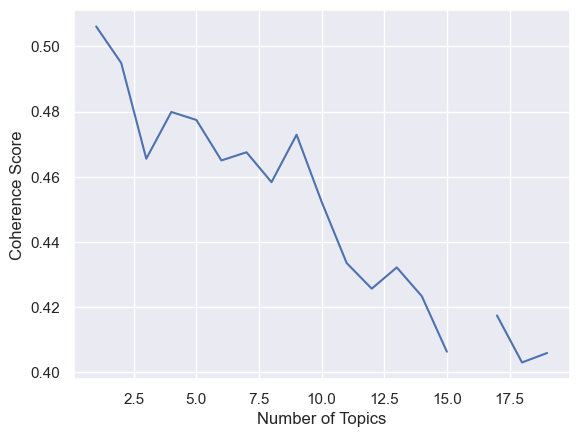

In [ ]:
# Calculate the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=sgPosCorp, id2word=sgPosDict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = sgNeg['tokens'], corpus=sgPosCorp, dictionary=sgPosDict, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Based on the 2 graphs above, the optimal number of topics for Singpore's Negative reviews using LDA is: 2

In [13]:
# LDA model building
sgPosLDA = LdaMulticore(corpus=sgPosCorp, 
                         id2word=sgPosDict, 
                         iterations=100, 
                         num_topics=2, 
                         workers = 4, 
                         passes=100)

sgPosLDA.print_topics(-1)

[(0,
  '0.057*"room" + 0.041*"good" + 0.021*"clean" + 0.017*"location" + 0.016*"small" + 0.014*"night" + 0.013*"bed" + 0.013*"bathroom" + 0.011*"nice" + 0.010*"price"'),
 (1,
  '0.050*"great" + 0.035*"location" + 0.031*"host" + 0.028*"clean" + 0.027*"nice" + 0.022*"apartment" + 0.018*"good" + 0.015*"helpful" + 0.015*"station" + 0.014*"convenient"')]

In [ ]:
sgPosLDAdisplay = pyLDAvis.gensim_models.prepare(sgPosLDA, sgPosCorp, sgPosDict)
pyLDAvis.display(sgPosLDAdisplay)

#### Sing Negative

In [ ]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
sgNegDict = Dictionary(sgNeg["tokens"])
# dictionary = Dictionary(sgNeg['tokensForLDA'])
print(sgNegDict.token2id)

# Filter dictionary
sgNegDict.filter_extremes(no_below=5, no_above=0.7, keep_n=1500)

# Create corpus
sgNegCorp = [sgNegDict.doc2bow(doc) for doc in sgNeg['tokens']]

{'bathroom': 0, 'bed': 1, 'board': 2, 'broken': 3, 'day': 4, 'disappointing': 5, 'double': 6, 'frame': 7, 'landlord': 8, 'maid': 9, 'morning': 10, 'next': 11, 'obvious': 12, 'people': 13, 'responsibility': 14, 'room': 15, 'single': 16, 'situation': 17, 'wooden': 18, 'hostel': 19, 'way': 20, 'accommodation': 21, 'cheap': 22, 'city': 23, 'clean': 24, 'crowded': 25, 'easy': 26, 'fast': 27, 'quiet': 28, 'solution': 29, 'top': 30, 'amenity': 31, 'basic': 32, 'charge': 33, 'convenient': 34, 'decoration': 35, 'extra': 36, 'need': 37, 'pc': 38, 'small': 39, 'storage': 40, 'thing': 41, 'toiletry': 42, 'tv': 43, 'usd': 44, 'well': 45, 'airport': 46, 'dirty': 47, 'good': 48, 'hair': 49, 'house': 50, 'job': 51, 'much': 52, 'night': 53, 'old': 54, 'owener': 55, 'sleep': 56, 'untidy': 57, 'hot': 58, 'water': 59, 'ant': 60, 'bad': 61, 'cancellation': 62, 'cramped': 63, 'curtain': 64, 'expensive': 65, 'first': 66, 'full': 67, 'impressed': 68, 'large': 69, 'message': 70, 'minute': 71, 'mosque': 72, 'op

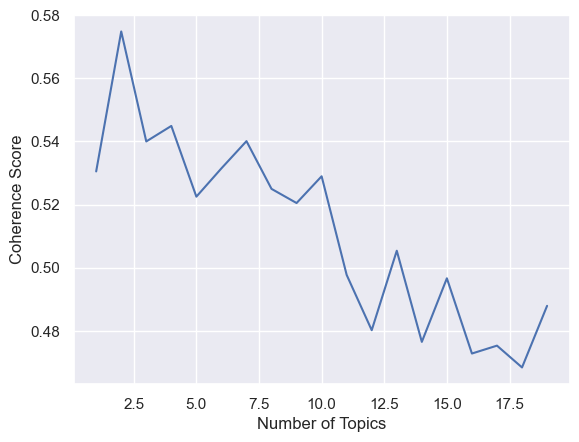

In [ ]:
# Calculate the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=sgNegCorp, id2word=sgNegDict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = sgNeg['tokens'], corpus=sgNegCorp, dictionary=sgNegDict, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Based on the 2 graphs above, the optimal number of topics for Singpore's Negative reviews using LDA is: 7

In [121]:
# LDA model building
# lda_model = LdaMulticore(corpus=corpus, 
#                          id2word=dictionary, 
#                          iterations=50, 
#                          num_topics=10, 
#                          workers = 7, 
#                          passes=10)
sgNegLDA = LdaMulticore(corpus=sgNegCorp, 
                         id2word=sgNegDict, 
                         iterations=100, 
                         num_topics=7, 
                         workers = 4, 
                         passes=100)
sgNegLDA.print_topics(-1)

[(0,
  '0.048*"apartment" + 0.040*"room" + 0.029*"clean" + 0.028*"location" + 0.021*"good" + 0.018*"area" + 0.016*"bathroom" + 0.014*"nice" + 0.014*"kitchen" + 0.013*"lot"'),
 (1,
  '0.044*"room" + 0.036*"night" + 0.030*"door" + 0.026*"time" + 0.018*"day" + 0.016*"loud" + 0.015*"noise" + 0.015*"hotel" + 0.015*"check" + 0.014*"next"'),
 (2,
  '0.073*"room" + 0.041*"small" + 0.033*"location" + 0.028*"good" + 0.026*"hotel" + 0.019*"price" + 0.016*"day" + 0.015*"bit" + 0.014*"accommodation" + 0.014*"night"'),
 (3,
  '0.047*"host" + 0.026*"room" + 0.026*"house" + 0.025*"day" + 0.014*"bad" + 0.013*"time" + 0.011*"experience" + 0.010*"night" + 0.009*"landlord" + 0.009*"photo"'),
 (4,
  '0.047*"room" + 0.039*"bed" + 0.025*"good" + 0.018*"kitchen" + 0.018*"small" + 0.014*"location" + 0.013*"clean" + 0.012*"people" + 0.011*"bug" + 0.009*"window"'),
 (5,
  '0.070*"room" + 0.034*"floor" + 0.025*"night" + 0.022*"bed" + 0.017*"noise" + 0.013*"good" + 0.012*"area" + 0.011*"bathroom" + 0.010*"man" + 0

In [ ]:
sgNegLDAdisplay = pyLDAvis.gensim_models.prepare(sgNegLDA, sgNegCorp, sgNegDict)
pyLDAvis.display(sgNegLDAdisplay)

#### Thai Positive

In [8]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
thPosDict = Dictionary(thPos["tokens"])
# dictionary = Dictionary(sgNeg['tokensForLDA'])
print(thPosDict.token2id)

# Filter dictionary
thPosDict.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
thPosCorp = [thPosDict.doc2bow(doc) for doc in thPos['tokens']]

{'accommodate': 0, 'apartment': 1, 'balcony': 2, 'bts': 3, 'bus': 4, 'central': 5, 'enjoy': 6, 'food': 7, 'good': 8, 'host': 9, 'location': 10, 'lot': 11, 'love': 12, 'mall': 13, 'massage': 14, 'min': 15, 'modern': 16, 'much': 17, 'next': 18, 'nice': 19, 'nuttee': 20, 'perfect': 21, 'recommend': 22, 'shopping': 23, 'spacious': 24, 'stall': 25, 'station': 26, 'supermarket': 27, 'taxi': 28, 'view': 29, 'visit': 30, 'walk': 31, 'week': 32, 'world': 33, 'abundance': 34, 'accessible': 35, 'area': 36, 'arrange': 37, 'arrive': 38, 'ask': 39, 'assistant': 40, 'base': 41, 'beautiful': 42, 'certain': 43, 'cleaning': 44, 'condo': 45, 'corner': 46, 'email': 47, 'experience': 48, 'exploration': 49, 'girlfriend': 50, 'great': 51, 'hope': 52, 'leave': 53, 'make': 54, 'meet': 55, 'month': 56, 'monument': 57, 'possible': 58, 'return': 59, 'see': 60, 'shop': 61, 'street': 62, 'suchart': 63, 'town': 64, 'victory': 65, 'well': 66, 'wonderful': 67, 'blue': 68, 'building': 69, 'center': 70, 'cheap': 71, 'ci

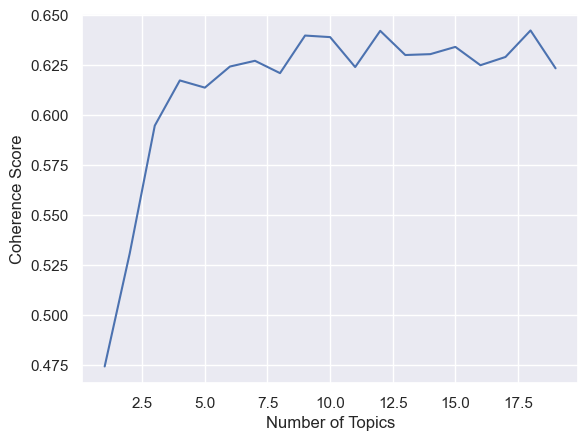

In [9]:
# Calculate the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=thPosCorp, id2word=thPosDict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = thPos['tokens'], corpus=thPosCorp, dictionary=thPosDict, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Based on the 2 graphs above, the optimal number of topics for Singpore's Negative reviews using LDA is: 9

In [20]:
thPosLDA = LdaMulticore(corpus=thPosCorp, 
                         id2word=thPosDict, 
                         iterations=100, 
                         num_topics=9, 
                         workers = 4, 
                         passes=100)
thPosLDA.print_topics(-1)

[(0,
  '0.086*"pool" + 0.067*"apartment" + 0.057*"view" + 0.040*"condo" + 0.037*"building" + 0.034*"great" + 0.034*"nice" + 0.034*"gym" + 0.034*"swimming" + 0.018*"beautiful"'),
 (1,
  '0.122*"great" + 0.078*"location" + 0.075*"host" + 0.071*"nice" + 0.069*"clean" + 0.045*"good" + 0.045*"recommend" + 0.035*"room" + 0.035*"helpful" + 0.030*"friendly"'),
 (2,
  '0.062*"host" + 0.061*"check" + 0.044*"easy" + 0.032*"great" + 0.024*"clean" + 0.024*"question" + 0.023*"respond" + 0.023*"quick" + 0.021*"apartment" + 0.021*"responsive"'),
 (3,
  '0.039*"room" + 0.029*"bed" + 0.024*"water" + 0.019*"kitchen" + 0.018*"work" + 0.018*"bathroom" + 0.016*"air" + 0.015*"machine" + 0.014*"clean" + 0.014*"shower"'),
 (4,
  '0.031*"take" + 0.026*"day" + 0.024*"go" + 0.023*"airport" + 0.021*"taxi" + 0.021*"help" + 0.018*"get" + 0.017*"time" + 0.017*"check" + 0.016*"arrive"'),
 (5,
  '0.108*"good" + 0.044*"room" + 0.043*"accommodation" + 0.039*"price" + 0.037*"bit" + 0.035*"location" + 0.023*"clean" + 0.019

In [25]:
thPosLDAdisplay = pyLDAvis.gensim_models.prepare(thPosLDA, thPosCorp, thPosDict)
pyLDAvis.display(thPosLDAdisplay)

#### Thai Negative

In [10]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
thNegDict = Dictionary(thNeg["tokens"])
# dictionary = Dictionary(sgNeg['tokensForLDA'])
print(thNegDict.token2id)

# Filter dictionary
thNegDict.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
thNegCorp = [thNegDict.doc2bow(doc) for doc in thNeg['tokens']]

{'accessible': 0, 'airport': 1, 'apartment': 2, 'ask': 3, 'avoid': 4, 'aware': 5, 'baht': 6, 'bar': 7, 'bath': 8, 'beautiful': 9, 'boat': 10, 'book': 11, 'center': 12, 'charge': 13, 'choose': 14, 'city': 15, 'come': 16, 'disappointed': 17, 'email': 18, 'essential': 19, 'evening': 20, 'host': 21, 'much': 22, 'name': 23, 'ordinary': 24, 'overlook': 25, 'pick': 26, 'pier': 27, 'pool': 28, 'prefer': 29, 'price': 30, 'respond': 31, 'restaurant': 32, 'site': 33, 'start': 34, 'swimming': 35, 'taxi': 36, 'time': 37, 'transport': 38, 'trip': 39, 'visit': 40, 'walk': 41, 'waste': 42, 'accommodation': 43, 'answer': 44, 'direction': 45, 'easy': 46, 'enjoy': 47, 'father': 48, 'find': 49, 'get': 50, 'meet': 51, 'need': 52, 'provide': 53, 'question': 54, 'quick': 55, 'sleep': 56, 'space': 57, 'sufficient': 58, 'able': 59, 'access': 60, 'add': 61, 'agree': 62, 'alleviate': 63, 'amount': 64, 'annoying': 65, 'apologize': 66, 'area': 67, 'arrive': 68, 'attention': 69, 'bacteria': 70, 'base': 71, 'bathroo

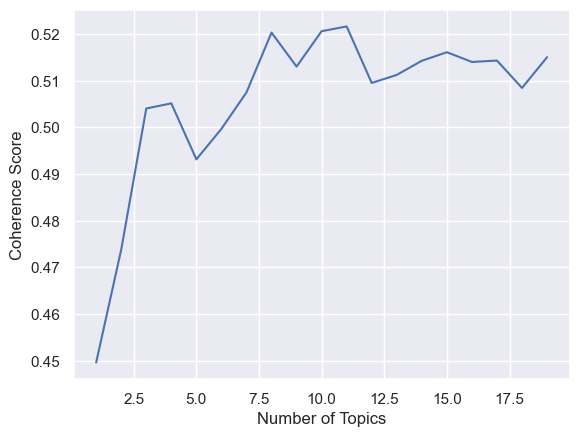

In [11]:
# Calculate the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=thNegCorp, id2word=thNegDict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = thNeg['tokens'], corpus=thNegCorp, dictionary=thNegDict, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Based on the 2 graphs above, the optimal number of topics for Thailand's Negative reviews using LDA is: 11

In [22]:
thNegLDA = LdaMulticore(corpus=thNegCorp, 
                         id2word=thNegDict, 
                         iterations=100, 
                         num_topics=11, 
                         workers = 4, 
                         passes=100)
thNegLDA.print_topics(-1)

[(0,
  '0.068*"location" + 0.052*"good" + 0.041*"bit" + 0.034*"price" + 0.030*"taxi" + 0.026*"find" + 0.022*"go" + 0.018*"room" + 0.017*"convenient" + 0.017*"take"'),
 (1,
  '0.056*"landlord" + 0.035*"day" + 0.030*"check" + 0.028*"room" + 0.024*"ask" + 0.024*"time" + 0.022*"house" + 0.016*"service" + 0.014*"pay" + 0.011*"come"'),
 (2,
  '0.094*"room" + 0.030*"night" + 0.029*"hotel" + 0.022*"house" + 0.021*"cockroach" + 0.018*"bed" + 0.016*"picture" + 0.015*"look" + 0.014*"feel" + 0.014*"good"'),
 (3,
  '0.046*"check" + 0.033*"key" + 0.028*"door" + 0.026*"wait" + 0.025*"go" + 0.025*"time" + 0.022*"get" + 0.016*"room" + 0.016*"card" + 0.016*"building"'),
 (4,
  '0.062*"room" + 0.034*"floor" + 0.025*"night" + 0.023*"noise" + 0.022*"sleep" + 0.022*"noisy" + 0.022*"door" + 0.018*"window" + 0.016*"sound" + 0.015*"house"'),
 (5,
  '0.037*"smell" + 0.032*"clean" + 0.030*"dirty" + 0.028*"bathroom" + 0.026*"towel" + 0.025*"bed" + 0.025*"toilet" + 0.024*"room" + 0.018*"stain" + 0.017*"bad"'),
 (6

In [ ]:
thNegLDAdisplay = pyLDAvis.gensim_models.prepare(thNegLDA, thNegCorp, thNegDict)
pyLDAvis.display(thNegLDAdisplay)

#### Turk Positive

In [12]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
trPosDict = Dictionary(trPos["tokens"])
# dictionary = Dictionary(sgNeg['tokensForLDA'])
print(trPosDict.token2id)

# Filter dictionary
trPosDict.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
trPosCorp = [trPosDict.doc2bow(doc) for doc in trPos['tokens']]

{'absence': 0, 'adorable': 1, 'apartment': 2, 'available': 3, 'bar': 4, 'calm': 5, 'cartier': 6, 'cd': 7, 'city': 8, 'clothe': 9, 'club': 10, 'condiment': 11, 'cupboard': 12, 'dinner': 13, 'dvds': 14, 'empty': 15, 'equip': 16, 'feel': 17, 'french': 18, 'go': 19, 'good': 20, 'great': 21, 'home': 22, 'ideal': 23, 'information': 24, 'invite': 25, 'kitchen': 26, 'library': 27, 'map': 28, 'neighbor': 29, 'plan': 30, 'public': 31, 'sheet': 32, 'silent': 33, 'spice': 34, 'stone': 35, 'tea': 36, 'throw': 37, 'tip': 38, 'transport': 39, 'trendy': 40, 'week': 41, 'welcome': 42, 'friend': 43, 'locate': 44, 'nice': 45, 'travel': 46, 'bathroom': 47, 'cafe': 48, 'close': 49, 'cozy': 50, 'ferry': 51, 'floor': 52, 'friendly': 53, 'helpful': 54, 'host': 55, 'living': 56, 'look': 57, 'lot': 58, 'minute': 59, 'multu': 60, 'original': 61, 'photo': 62, 'quiet': 63, 'recommend': 64, 'restaurant': 65, 'room': 66, 'spacious': 67, 'spot': 68, 'stop': 69, 'street': 70, 'well': 71, 'window': 72, 'wooden': 73, 'b

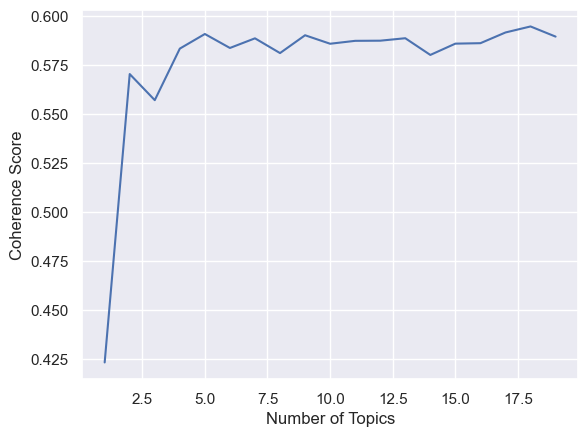

In [13]:
# Calculate the coherence score using C_umass
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=trPosCorp, id2word=trPosDict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = trPos['tokens'], corpus=trPosCorp, dictionary=trPosDict, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Based on the 2 graphs above, the optimal number of topics for Turkey's Positive reviews using LDA is: 5

In [23]:
trPosLDA = LdaMulticore(corpus=trPosCorp, 
                         id2word=trPosDict, 
                         iterations=100, 
                         num_topics=5, 
                         workers = 4, 
                         passes=100)
trPosLDA.print_topics(-1)

[(0,
  '0.044*"apartment" + 0.033*"room" + 0.021*"bed" + 0.021*"good" + 0.019*"floor" + 0.017*"bathroom" + 0.016*"kitchen" + 0.016*"small" + 0.014*"nice" + 0.014*"clean"'),
 (1,
  '0.044*"apartment" + 0.043*"walk" + 0.032*"restaurant" + 0.027*"minute" + 0.024*"great" + 0.022*"location" + 0.021*"close" + 0.020*"area" + 0.019*"shop" + 0.016*"clean"'),
 (2,
  '0.055*"clean" + 0.055*"location" + 0.050*"good" + 0.050*"house" + 0.046*"host" + 0.041*"great" + 0.038*"nice" + 0.033*"recommend" + 0.032*"apartment" + 0.023*"helpful"'),
 (3,
  '0.039*"great" + 0.035*"host" + 0.029*"apartment" + 0.028*"view" + 0.026*"home" + 0.025*"amazing" + 0.025*"feel" + 0.023*"recommend" + 0.021*"location" + 0.018*"beautiful"'),
 (4,
  '0.021*"check" + 0.018*"help" + 0.017*"time" + 0.015*"day" + 0.014*"need" + 0.012*"get" + 0.012*"water" + 0.011*"take" + 0.011*"make" + 0.011*"go"')]

In [ ]:
trPosLDAdisplay = pyLDAvis.gensim_models.prepare(trPosLDA, trPosCorp, trPosDict)
pyLDAvis.display(trPosLDAdisplay)

#### Turk Negative

In [14]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
trNegDict = Dictionary(trNeg["tokens"])
# dictionary = Dictionary(sgNeg['tokensForLDA'])
print(trNegDict.token2id)

# Filter dictionary
trNegDict.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
trNegCorp = [trNegDict.doc2bow(doc) for doc in trNeg['tokens']]

{'ask': 0, 'balcony': 1, 'bedroom': 2, 'costly': 3, 'darkish': 4, 'floor': 5, 'get': 6, 'happy': 7, 'light': 8, 'many': 9, 'mehmet': 10, 'photo': 11, 'promise': 12, 'reaction': 13, 'sad': 14, 'single': 15, 'sunny': 16, 'thing': 17, 'top': 18, 'connection': 19, 'damage': 20, 'environment': 21, 'infest': 22, 'internet': 23, 'mold': 24, 'room': 25, 'time': 26, 'water': 27, 'weak': 28, 'able': 29, 'accommodation': 30, 'ad': 31, 'area': 32, 'breakfast': 33, 'carpet': 34, 'clean': 35, 'climb': 36, 'clothe': 37, 'coffee': 38, 'complaint': 39, 'cordial': 40, 'cup': 41, 'dirty': 42, 'dog': 43, 'door': 44, 'downside': 45, 'dry': 46, 'easy': 47, 'enjoy': 48, 'example': 49, 'fact': 50, 'favor': 51, 'feel': 52, 'foot': 53, 'good': 54, 'guest': 55, 'hard': 56, 'heating': 57, 'home': 58, 'hospitality': 59, 'house': 60, 'housing': 61, 'impression': 62, 'inexpensive': 63, 'lazy': 64, 'let': 65, 'locate': 66, 'look': 67, 'lot': 68, 'man': 69, 'mention': 70, 'naked': 71, 'need': 72, 'neighbor': 73, 'owne

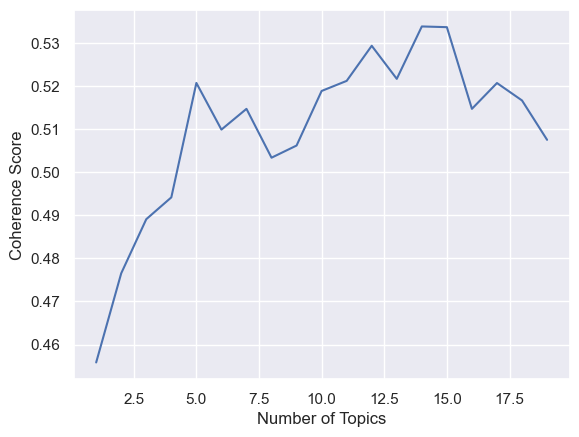

In [15]:
# Calculate the coherence score using C_umass
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=trNegCorp, id2word=trNegDict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = trNeg['tokens'], corpus=trNegCorp, dictionary=trNegDict, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Based on the 2 graphs above, the optimal number of topics for Turkey's Negative reviews using LDA is: 14

In [24]:
trNegLDA = LdaMulticore(corpus=trNegCorp, 
                         id2word=trNegDict, 
                         iterations=100, 
                         num_topics=14, 
                         workers = 4, 
                         passes=100)
trNegLDA.print_topics(-1)

[(0,
  '0.102*"water" + 0.050*"work" + 0.040*"shower" + 0.040*"day" + 0.038*"hot" + 0.032*"problem" + 0.028*"cold" + 0.026*"internet" + 0.024*"wifi" + 0.019*"time"'),
 (1,
  '0.185*"house" + 0.032*"problem" + 0.028*"clean" + 0.024*"home" + 0.023*"location" + 0.017*"landlord" + 0.016*"enter" + 0.015*"good" + 0.013*"owner" + 0.011*"cleanliness"'),
 (2,
  '0.099*"bed" + 0.071*"apartment" + 0.035*"small" + 0.033*"uncomfortable" + 0.033*"sleep" + 0.033*"people" + 0.025*"mattress" + 0.022*"family" + 0.022*"comfortable" + 0.020*"bedroom"'),
 (3,
  '0.157*"smell" + 0.099*"bad" + 0.075*"room" + 0.043*"bathroom" + 0.027*"smoke" + 0.023*"cigarette" + 0.019*"dirty" + 0.019*"experience" + 0.018*"strong" + 0.015*"cat"'),
 (4,
  '0.062*"floor" + 0.047*"apartment" + 0.047*"stair" + 0.039*"elevator" + 0.027*"building" + 0.024*"difficult" + 0.022*"luggage" + 0.022*"parking" + 0.019*"car" + 0.019*"narrow"'),
 (5,
  '0.033*"host" + 0.024*"day" + 0.021*"check" + 0.018*"leave" + 0.018*"ask" + 0.017*"time" +

In [ ]:
trNegLDAdisplay = pyLDAvis.gensim_models.prepare(trNegLDA, trNegCorp, trNegDict)
pyLDAvis.display(trNegLDAdisplay)

# Save Model - for deployment

## BERTopic

In [49]:
sgPosTopicMod.save("./models/sgPosBERT", serialization="safetensors")
sgNegTopicMod.save("./models/sgNegBERT", serialization="safetensors")
# Thai Pos & Neg model
thPosTopicMod.save("./models/thPosBERT", serialization="safetensors")
thNegTopicMod.save("./models/thNegBERT", serialization="safetensors")
# Turk Pos & Neg model
trPosTopicMod.save("./models/trPosBERT", serialization="safetensors")
trNegTopicMod.save("./models/trNegBERT", serialization="safetensors")

In [200]:
# test load model
testBModel = BERTopic.load("sgPosBERT")
testBModel.visualize_barchart()

## Latent Dirichlet Allocation (LDA)

In [29]:
# Save the report
pyLDAvis.save_html(sgPosLDAdisplay, './models/sgPosLDAdisplay.html')
pyLDAvis.save_html(sgNegLDAdisplay, './models/sgNegLDAdisplay.html')
pyLDAvis.save_html(thPosLDAdisplay, './models/thPosLDAdisplay.html')
pyLDAvis.save_html(thNegLDAdisplay, './models/thNegLDAdisplay.html')
pyLDAvis.save_html(trPosLDAdisplay, './models/trPosLDAdisplay.html')
pyLDAvis.save_html(trNegLDAdisplay, './models/trNegLDAdisplay.html')

In [33]:
sgPosLDA.save("./models/sgPosLDA")
sgNegLDA.save("./models/sgNegLDA")
thPosLDA.save("./models/thPosLDA")
thNegLDA.save("./models/thNegLDA")
trPosLDA.save("./models/trPosLDA")
trNegLDA.save("./models/trNegLDA")

# test gpu

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()
device

device(type='cuda')